In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from dataloader import xr_standardize_field

import torch.nn as nn
import torch.optim as optim

import xarray as xr
import numpy as np
import torch
import glob

from dataloader import NetCDFSR, xr_standardize_field
import xarray as xr
import numpy as np
import glob
import torch
import datetime
import pandas as pd
from prep_gan import find_nearest_index, to_utc

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.interpolate import NearestNDInterpolator

import seaborn as sns


import matplotlib.pyplot as plt

plt.style.use(['science','no-latex'])
plt.rcParams.update({"figure.figsize":  (5,10),
                    'font.family': 'Times New Roman',
                    'font.size': 25,
                    'lines.linewidth': 2.5})


from models.generator import Generator
from models.critic import Critic
# import geopandas as gpd

%load_ext autoreload
%autoreload 2

torch.cuda.empty_cache()
import dask
dask.config.set({"array.slicing.split_large_chunks": True})

In [2]:
from distributed import Client

# Depending on your workstation specifications, you may need to adjust these values.
# On a single machine, n_workers=1 is usually better.
client=Client(n_workers=4, threads_per_worker=1, memory_limit="4GB")
client

Client Scheduler: tcp://127.0.0.1:37933 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 14.90 GiB


In [3]:
hr_dataroot_U10 = "data/wrf/U10/regrid_10_6hrly_wrf2d_d01_ctrl_U10*.nc"
hr_dataroot_V10 = "data/wrf/V10/regrid_10_6hrly_wrf2d_d01_ctrl_V10*.nc"

hr_dataroot_U10 = "data/wrf/U10_regrid_16/regrid_16_6hrly_wrf2d_d01_ctrl_U10*.nc"
hr_dataroot_V10 = "data/wrf/V10_regrid_16/regrid_16_6hrly_wrf2d_d01_ctrl_V10*.nc"

fine_u = xr.open_mfdataset(glob.glob(hr_dataroot_U10), combine='by_coords', engine='netcdf4', concat_dim='Time', chunks={"Times":10})
fine_v = xr.open_mfdataset(glob.glob(hr_dataroot_V10), combine='by_coords', engine='netcdf4', concat_dim='Time', chunks={"Times":10})

dataroot = "./data/interim_2000-10-01_to_2013-09-30.nc"

target = '10UV_GDS4_SFC'
coarse = xr.open_dataset(dataroot).astype("float")
coarse = coarse.sortby('latitude', ascending=True)
coarse_u10 = coarse.u10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})
coarse_v10 = coarse.v10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})

# scale factor
sf = 8

In [4]:
Times_dt = []
for t in fine_u.Times:
    year = int(str(float(t))[:4])
    month = int(str(float(t))[4:6])
    day = int(str(float(t))[6:8])
    hours = int(np.round(24*float(str(float(t))[8:])))
    Times_dt.append(np.datetime64(datetime.datetime(year, month, day, hours)))
Times_dt = np.array(Times_dt).astype('datetime64[D]')
Times_dt_pd = pd.DatetimeIndex(Times_dt)
filter_func = np.vectorize(lambda x: True if x.month in [6, 7, 8, 9, 10] else False)
time_mask = filter_func(Times_dt_pd.astype(object))

In [5]:
i_list = np.arange(len(time_mask))
i_list[time_mask]

array([    0,     1,     2, ..., 18989, 18990, 18991])

In [6]:
# low, up, l, r = 9, 19, 75, 85
low, up, l, r = 4, 20, 70, 86

In [7]:
u10 = fine_u.U10[:, sf*low:sf*up, sf*l:sf*r]
v10 = fine_v.V10[:, sf*low:sf*up, sf*l:sf*r]

coarse_u10 = coarse.u10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})
coarse_v10 = coarse.v10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})

coarse_u10_patch = coarse_u10[:, low:up, l:r]
coarse_v10_patch = coarse_v10[:, low:up, l:r]

u10 = xr_standardize_field(u10)
v10 = xr_standardize_field(v10)
coarse_u10 =  xr_standardize_field(coarse_u10_patch)
coarse_v10 =  xr_standardize_field(coarse_v10_patch)

In [8]:
# coarse_u10[18, ...].values
u10

<xarray.DataArray 'U10' (Times: 18992, lat: 128, lon: 128)>
dask.array<truediv, shape=(18992, 128, 128), dtype=float32, chunksize=(10, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * Times    (Times) float64 2e+07 2e+07 2e+07 ... 2.013e+07 2.013e+07 2.013e+07
  * lon      (lon) float32 -86.55 -86.46 -86.37 -86.27 ... -74.84 -74.74 -74.65
  * lat      (lat) float32 21.14 21.23 21.32 21.42 ... 32.76 32.86 32.95 33.04

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


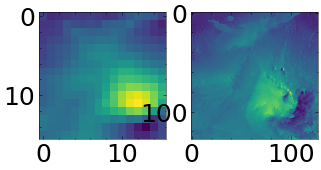

In [9]:
fig,ax = plt.subplots(1, 2)
ax[0].imshow(coarse_u10[18, ...])
ax[1].imshow(u10[18, ...])

In [10]:
coarse = np.stack([coarse_u10, coarse_v10], axis=1)
fine = np.stack([u10, v10], axis=1)

# coarse = xr.concat([coarse_u10, coarse_v10], dim="var").transpose('time', 'var', 'latitude', 'longitude')
# fine = xr.concat([u10, v10], dim="var").transpose('Times', 'var', 'lat', 'lon')

In [11]:
fine_t = torch.from_numpy(fine)#.double()
coarse_t = torch.from_numpy(coarse)#.double()

In [12]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

class NetCDFSR(Dataset):
    """Data loader for netCDF data for GAN Super Resolution"""

    def __init__(
        self,
        fine,
        coarse,
        times,
        device = device):
        """
        Args:
            mdsarr (xarray.MultiDataset): fine scale dataset
            mdscoarse (xarray.MultiDataset): fine coarse scale dataset
            transforms (torch.transform.Compose): default None, preprocessing image transforms
            norm (bool): whether to normalize/standardize data
            mean (float): which mean to standardize to
            std (float): which stdev to standardize to
        """
        self.fine = fine[times, ...]#.to(device)
        self.coarse = coarse[times, ...]#.to(device)

    def __len__(self):
        return self.fine.shape[0]
    
    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        arr = self.fine[idx, ...]
        carr = self.coarse[idx, ...]

#         arr = torch.unsqueeze(arr, 0)
#         carr = torch.unsqueeze(carr, 0)

#         arr = torch.from_numpy(arr)#.long().float()
#         carr = torch.from_numpy(carr)#.long().float()

        return arr, carr

dataset = NetCDFSR(
    fine_t,
    coarse_t,
    i_list[time_mask][:1000],
    device=device,
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=1000,
    shuffle=True
)

real_batch, real_cbatch = next(iter(dataloader))
fixed = {"coarse": real_cbatch, "fine": real_batch}
fixed["coarse"].size()

torch.Size([1000, 2, 16, 16])

In [13]:
import mlflow
logged_model = 'file:///home/nannau/msc/DoWnGAN/mlruns/1/6a97a5566a224afea816dd0a50fe72fa/artifacts/Generator'

# Load model as a PyFuncModel.
# loaded_model = mlflow.pyfunc.load_model(logged_model)
G = mlflow.pytorch.load_model(logged_model).to(device)

# state_dict_uri = mlflow.get_artifact_uri(artifact_path)
state_dict = mlflow.pytorch.load_state_dict("/home/nannau/msc/DoWnGAN/mlruns/1/6a97a5566a224afea816dd0a50fe72fa/artifacts/Generator/")#state_dict.pth")
G.load_state_dict(state_dict)

<All keys matched successfully>

In [14]:
u10_fake = G(fixed["coarse"].float().to(device)).detach().cpu().numpy()[:, 0, ...]
v10_fake = G(fixed["coarse"].float().to(device)).detach().cpu().numpy()[:, 1, ...]

In [15]:
coarse_wrf = torch.from_numpy(xr.DataArray(fixed["fine"]).coarsen(dim_2=8).mean().coarsen(dim_3=8).mean().values).to(device)
coarse_wrf_hypot = np.hypot(coarse_wrf.detach().cpu().numpy()[:, 0, ...], coarse_wrf.detach().cpu().numpy()[:, 1, ...])
coarse_hypot = np.hypot(fixed["coarse"].detach().numpy()[:, 0, ...], fixed["coarse"].detach().numpy()[:, 1, ...])

u10_wrf_fake = G(coarse_wrf).detach().cpu().numpy()[:, 0, ...]
v10_wrf_fake = G(coarse_wrf).detach().cpu().numpy()[:, 1, ...]

u10_real = fixed["fine"].detach().numpy()[:, 0, ...]
v10_real = fixed["fine"].detach().numpy()[:, 1, ...]

In [16]:
u10_wrf_fake.shape, u10_fake.shape, coarse_wrf_hypot.shape, coarse_hypot.shape

((1000, 128, 128), (1000, 128, 128), (1000, 16, 16), (1000, 16, 16))

In [17]:
import multiprocessing

In [18]:
mse_fake_arr, mse_fake_wrf_coarse_arr, mse_wrf_coarse_arr = [], [], []
for i in range(991):
# def calc_stuff(i):
#     coarse_hypot = np.hypot(fixed["coarse"].detach().numpy()[i, 0, ...], fixed["coarse"].detach().numpy()[i, 1, ...])
        
#     u10_fake = G(fixed["coarse"].float().to(device)).detach().cpu().numpy()[i, 0, ...]
#     v10_fake = G(fixed["coarse"].float().to(device)).detach().cpu().numpy()[i, 1, ...]

#     real = fixed["fine"].detach().numpy()[i, 1, ...]

#     u10_real = fixed["fine"].detach().numpy()[i, 0, ...]
#     v10_real = fixed["fine"].detach().numpy()[i, 1, ...]

#     coarse_wrf = torch.from_numpy(xr.DataArray(fixed["fine"]).coarsen(dim_2=8).mean().coarsen(dim_3=8).mean().values).to(device)
#     coarse_wrf_hypot = np.hypot(coarse_wrf.detach().cpu().numpy()[i, 0, ...], coarse_wrf.detach().cpu().numpy()[i, 1, ...])
    
#     u10_wrf_fake = G(coarse_wrf).detach().cpu().numpy()[i, 0, ...]
#     v10_wrf_fake = G(coarse_wrf).detach().cpu().numpy()[i, 1, ...]
    speed_wrf_fake = np.hypot(u10_wrf_fake[i, ...], v10_wrf_fake[i, ...])

    speed_fake = np.hypot(u10_fake[i, ...], v10_fake[i, ...])
    speed_real = np.hypot(u10_real[i, ...], v10_real[i, ...])
    
    
#     flin_u10 = interp2d(x, y, fixed["coarse"].detach().numpy()[i, 0, ...], kind='linear')
#     naive_lin_u10 = flin_u10(nx, ny)
        
#     flin_v10 = interp2d(x, y, fixed["coarse"].detach().numpy()[i, 1, ...], kind='linear')
#     naive_lin_v10 = flin_v10(nx, ny)
    
#     naive_lin_speed = np.hypot(naive_lin_u10, naive_lin_v10)

#     mse_naive = mean_squared_error(naive_lin_speed.flatten(), speed_real.flatten())
    mse_fake = mean_squared_error(speed_fake.flatten(), speed_real.flatten())
    mse_fake_wrf_coarse = mean_squared_error(speed_wrf_fake.flatten(), speed_real.flatten())
    mse_wrf_coarse = mean_squared_error(coarse_wrf_hypot[i, ...].flatten(), coarse_hypot[i, ...].flatten())
    
    mse_fake_arr.append(mse_fake)
    mse_fake_wrf_coarse_arr.append(mse_fake_wrf_coarse)
    mse_wrf_coarse_arr.append(mse_wrf_coarse)
#     return (mse_fake, mse_fake_wrf_coarse, mse_wrf_coarse)

# pool = multiprocessing.Pool(8)
# mse_fake_arr, mse_fake_wrf_coarse_arr, mse_wrf_coarse_arr = zip(*pool.map(calc_stuff, range(1000)))

Text(0.5, 1.0, 'Paired Pixel Difference of Two Downscalings fixed G16, C8, $L = L_{EOF, 25}+L_c + \\gamma L_{adv}$')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


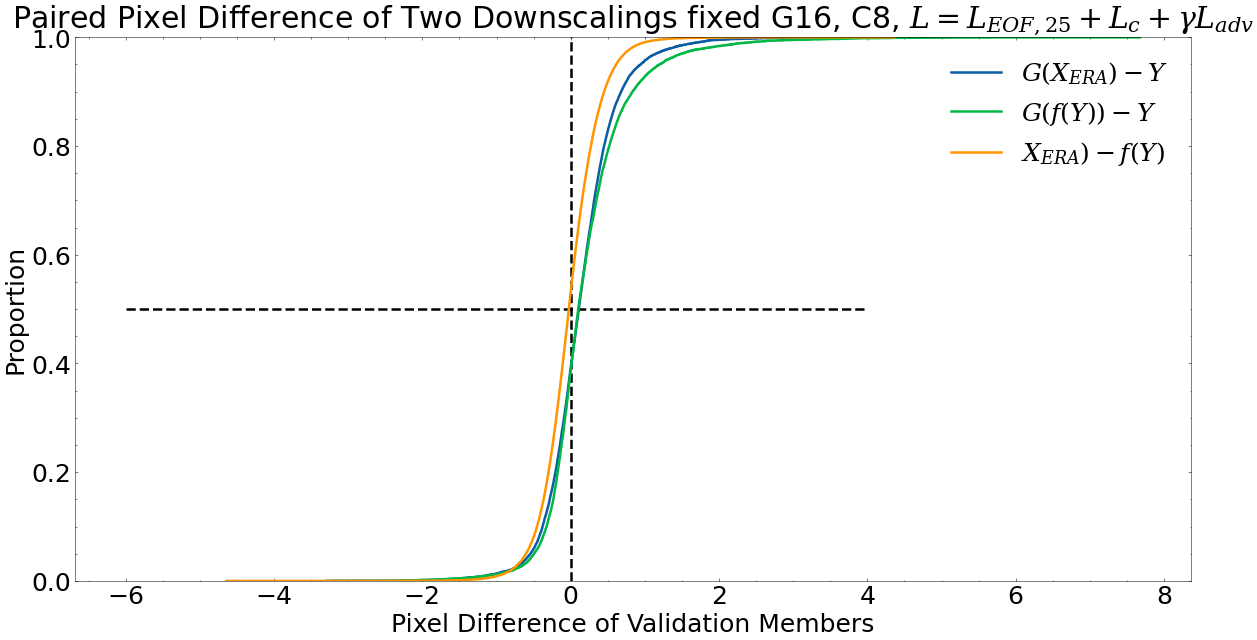

In [19]:
# difference
diff_reg = speed_fake - speed_real
diff_wrf = speed_wrf_fake - speed_real
diff_coarse = coarse_wrf_hypot - coarse_hypot

plt.figure(figsize=(20,10))
sns.ecdfplot(diff_reg.flatten(), label="$G(X_{ERA}) - Y$")
sns.ecdfplot(diff_wrf.flatten(), label="$G(f(Y)) - Y$")
sns.ecdfplot(diff_coarse.flatten(), label="$X_{ERA}) - f(Y)$")
plt.legend()
plt.vlines(0, 0, 1., linestyle="--", color="black")
plt.hlines(0.5, -6, 4., linestyle="--", color="black")

plt.xlabel("Pixel Difference of Validation Members")

plt.xlabel("Pixel Difference of Validation Members")

plt.title(r"Paired Pixel Difference of Two Downscalings fixed G16, C8, $L = L_{EOF, 25}+L_c + \gamma L_{adv}$")

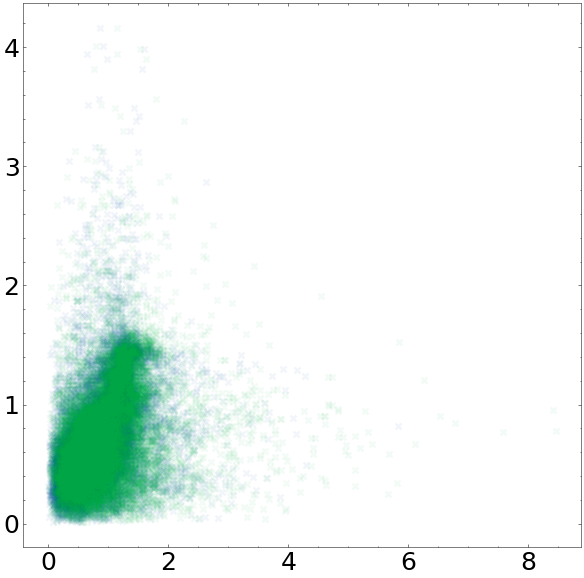

In [20]:
plt.figure(figsize=(10, 10))
plt.scatter(speed_fake.flatten(), speed_real.flatten(), marker="x", alpha=0.05)
plt.scatter(speed_wrf_fake.flatten(), speed_real.flatten(), marker="x", alpha=0.05)

In [21]:
len(mse_fake_arr)
from sklearn.metrics import r2_score

/home/nannau/tri/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nannau/tri/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nannau/tri/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

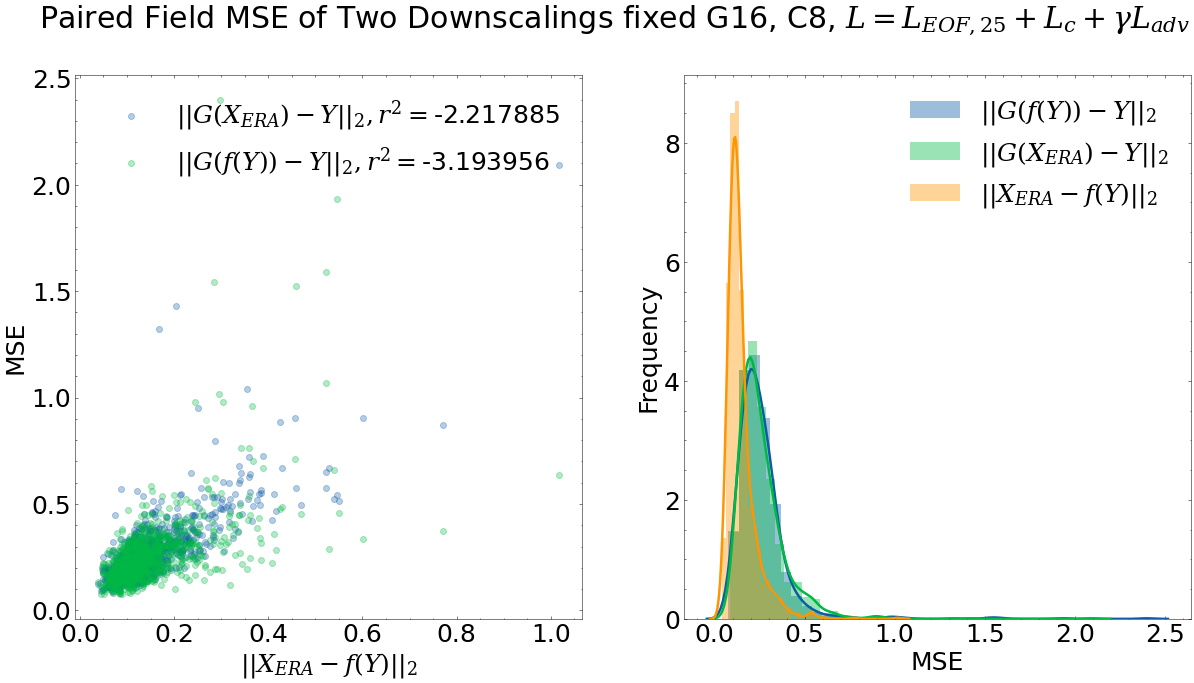

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].scatter(mse_wrf_coarse_arr, mse_fake_arr, label=r"$||G(X_{ERA}) - Y||_2, r^2=$%f"%(r2_score(mse_wrf_coarse_arr, mse_fake_arr)), alpha=0.3)
ax[0].scatter(mse_wrf_coarse_arr, mse_fake_wrf_coarse_arr, label=r"$||G(f(Y)) - Y||_2, r^2=$%f"%(r2_score(mse_wrf_coarse_arr, mse_fake_wrf_coarse_arr)), alpha=0.3)
ax[0].set_xlabel(r"$||X_{ERA} -  f(Y)||_2$")
ax[0].set_ylabel("MSE")
ax[0].legend()

import seaborn as sns

sns.distplot(mse_fake_wrf_coarse_arr, bins=40, label=r"$||G(f(Y)) - Y||_2$", ax=ax[1])
sns.distplot(mse_fake_arr, bins=40, label=r"$||G(X_{ERA}) - Y||_2$", ax=ax[1])
sns.distplot(mse_wrf_coarse_arr, bins=40, label=r"$||X_{ERA} - f(Y)||_2$", ax=ax[1])
ax[1].set_xlabel("MSE")
ax[1].set_ylabel("Frequency")
ax[1].legend()

# fig.suptitle(r"Paired Field MSE of Two Downscalings fixed G, $L = L_{vort} + L_{div}+L_{EOF, 25}+L_c + \gamma L_{adv}$")
fig.suptitle(r"Paired Field MSE of Two Downscalings fixed G16, C8, $L = L_{EOF, 25}+L_c + \gamma L_{adv}$")
plt.savefig("artifacts/joint_plots_89ab7d6b0c9e447fa7ae3ca30044f06c_extended")

In [23]:
import mlflow
hashed = "5347f0446e364ece98f3d652436f8462"
logged_model = f'file:///home/nannau/msc/DoWnGAN/mlruns/1/{hashed}/artifacts/Generator'

# Load model as a PyFuncModel.
# loaded_model = mlflow.pyfunc.load_model(logged_model)
G = mlflow.pytorch.load_model(logged_model).to(device)

# state_dict_uri = mlflow.get_artifact_uri(artifact_path)
state_dict = mlflow.pytorch.load_state_dict(logged_model)#state_dict.pth")
G.load_state_dict(state_dict)
# loaded_model(fixed["coarse"].to(device))

<All keys matched successfully>

In [24]:
# state = torch.load("checkpoints/losses/20210331-235010")
# state = torch.load("checkpoints/losses/20210423-230231")
# state = torch.load("checkpoints/losses/20210424-163047")
# state = torch.load("checkpoints/losses/20210424-095749")
# state = torch.load("checkpoints/losses/20210427-124527") # Structural loss with amplified trailing EOFs
# state = torch.load("checkpoints/losses/20210427-183446")
# state = torch.load("checkpoints/losses/20210427-231215") # Structural loss without amplified trailing EOFs
# state = torch.load("checkpoints/losses/20210428-013842") # No EOFs
# state = torch.load("checkpoints/losses/20210428-111811") # No EOFs
# state = torch.load("checkpoints/losses/20210513-100115") # No EOFs
# state = torch.load("checkpoints/losses/20210517-033357")

In [25]:
# G.load_state_dict(state["generator"])

In [26]:
coarse_t.size()

torch.Size([18992, 2, 16, 16])

In [27]:
batch_size=64
i = np.random.randint(0, batch_size)
# fake = G(fixed["coarse"])[i, 0, ...]
# real = fixed["fine"].detach().numpy()[i, 0, ...]
# coarse = fixed["coarse"].detach().numpy()[i, 0, ...]

In [28]:
# fake.detach().numpy()
real = fixed["fine"][i, 1, ...].detach().numpy()
coarse = fixed["coarse"][i, 1, ...].detach().numpy()

Text(0.5, 1.0, 'Ground Truth')

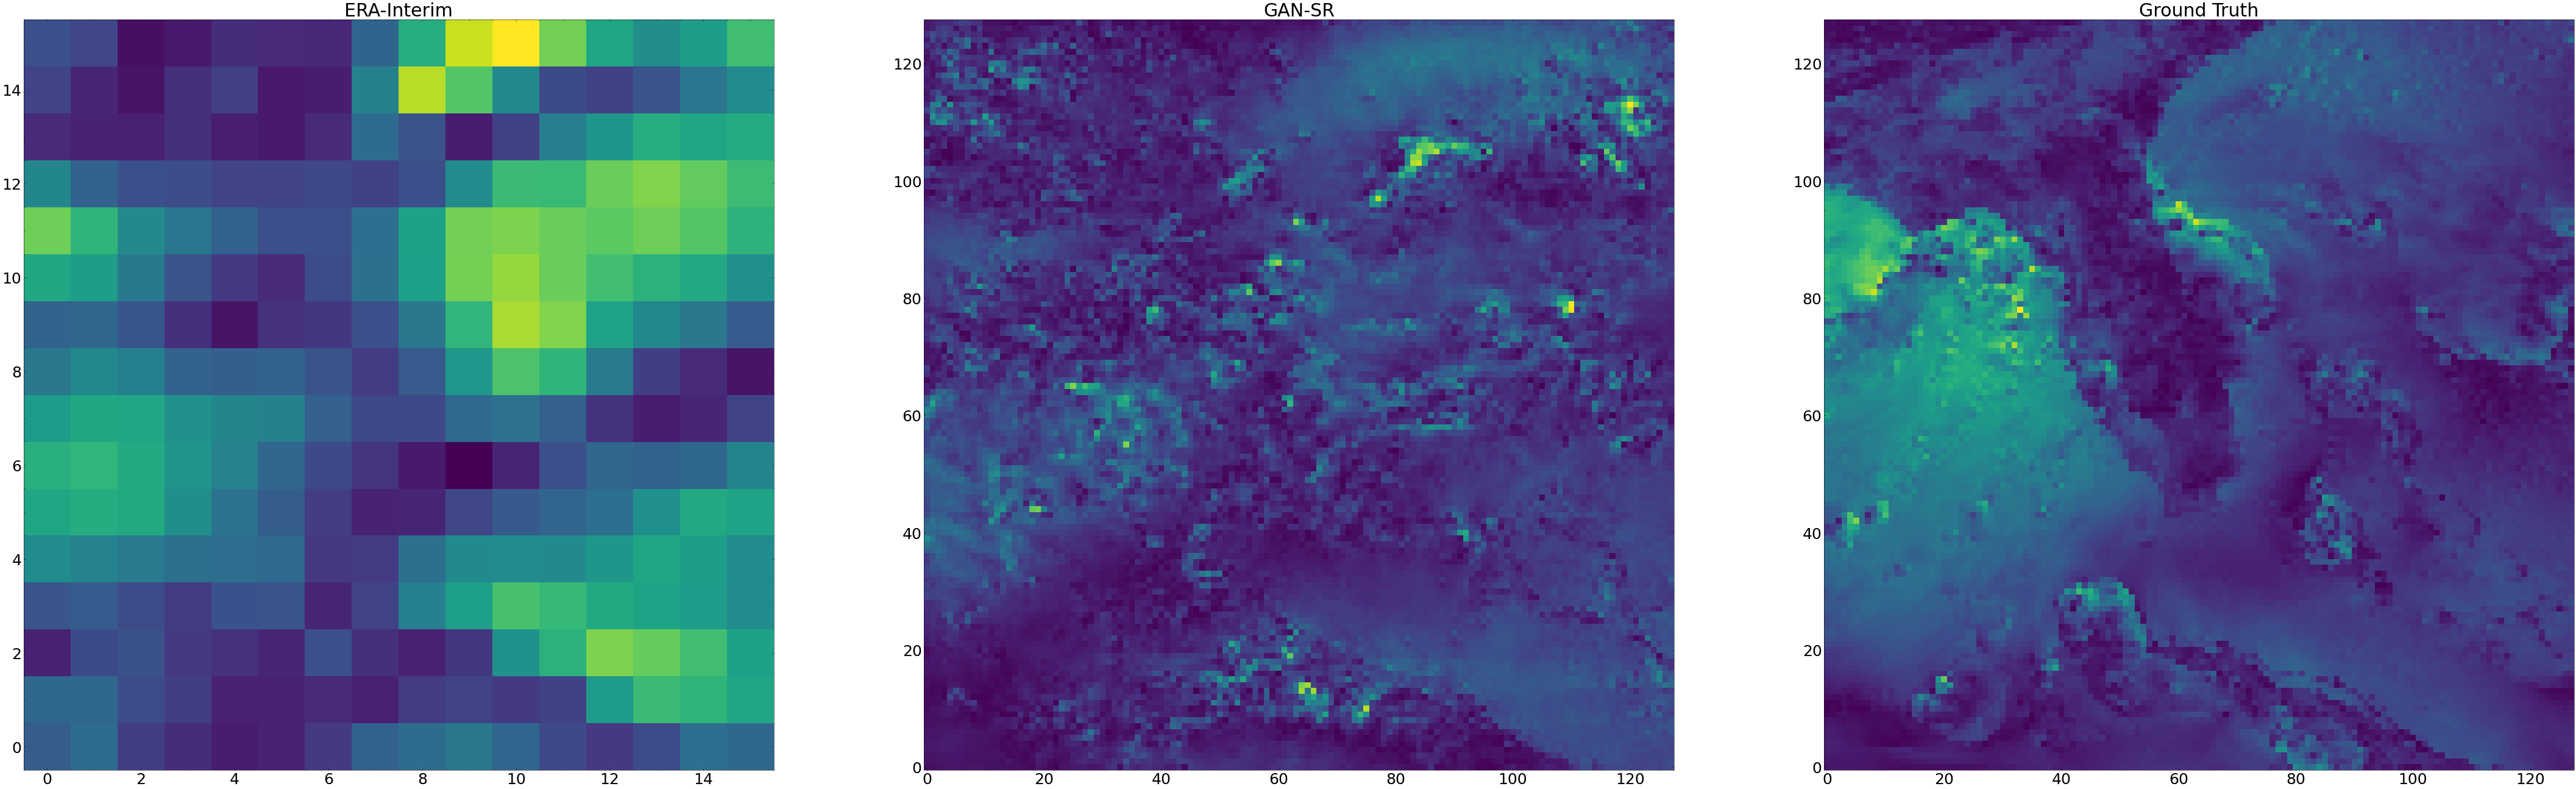

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(75, 75))
# np.random.seed(500)
i = np.random.randint(0, batch_size)

N1 = 3
N2 = N1+3
    
# i = np.random.randint(0, batch_size)

# real = fixed["fine"][i, 1, ...].detach().numpy()
# coarse = fixed["coarse"][i, 1, ...].detach().numpy()

coarse_hypot = np.hypot(
    fixed["coarse"][i, 0, ...].detach().numpy(),
    fixed["coarse"][i, 1, ...].detach().numpy()
)

u10_fake = G(fixed["coarse"].float().to(device))[i, 0, ...].detach().cpu().numpy()
v10_fake = G(fixed["coarse"].float().to(device))[i, 1, ...].detach().cpu().numpy()

real = fixed["fine"][i, 1, ...].detach().numpy()

u10_real = fixed["fine"][i, 0, ...].detach().numpy()
v10_real = fixed["fine"][i, 1, ...].detach().numpy()

speed_fake = np.hypot(u10_fake, v10_fake)
speed_real = np.hypot(u10_real, v10_real)

#     flin = interp2d(x, y, coarse, kind='linear')
#     naive_lin = flin(nx, ny)

# Regressing leading EOFs
#     reg = LinearRegression().fit(fine_sp_basis_v10.T, real.flatten())
#     leading_eofs = reg.predict(fine_sp_basis_v10.T).reshape(real.shape)

ax[0].imshow(coarse_hypot, origin="lower")
ax[0].set_title("ERA-Interim")
ax[1].imshow(speed_fake, origin="lower")
ax[1].set_title("GAN-SR")
ax[2].imshow(speed_real, origin="lower")
ax[2].set_title("Ground Truth")

In [30]:
from scipy.interpolate import interp2d
x = np.arange(coarse.shape[0])
y = np.arange(coarse.shape[1])
nx = np.linspace(x.min(), x.max(), sf*x.shape[0])
ny = np.linspace(y.min(), y.max(), sf*y.shape[0])

In [31]:
# u10_mean = float(np.mean(coarse_u10))
# v10_mean = float(np.mean(coarse_v10))
# u10_std = float(np.std(coarse_u10))
# v10_std = float(np.std(coarse_v10))
# u10_mean

In [32]:
#     coarse_wrf_u10 = torch.from_numpy(xr.DataArray(u10_real).coarsen(dim_0=8).mean().coarsen(dim_1=8).mean().values)
#     coarse_wrf_v10 = torch.from_numpy(xr.DataArray(v10_real).coarsen(dim_0=8).mean().coarsen(dim_1=8).mean().values)

xr.DataArray(fixed["fine"]).coarsen(dim_2=8).mean().coarsen(dim_3=8).mean().values.shape

(1000, 2, 16, 16)

In [33]:
import datetime
import pandas as pd
Times_dt = []
for t in fine_u.Times:
    year = int(str(float(t))[:4])
    month = int(str(float(t))[4:6])
    day = int(str(float(t))[6:8])
    hours = int(np.round(24*float(str(float(t))[8:])))
    Times_dt.append(np.datetime64(datetime.datetime(year, month, day, hours)))
Times_dt = np.array(Times_dt).astype('datetime64[D]')
Times_dt_pd = pd.DatetimeIndex(Times_dt)
filter_func = np.vectorize(lambda x: True if x.month in [6, 7, 8, 9, 10] else False)
time_mask = filter_func(Times_dt_pd.astype(object))

In [34]:
i_list = np.arange(len(time_mask))
i_list[time_mask]

array([    0,     1,     2, ..., 18989, 18990, 18991])

i 50
i 60
i 58
i 14


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


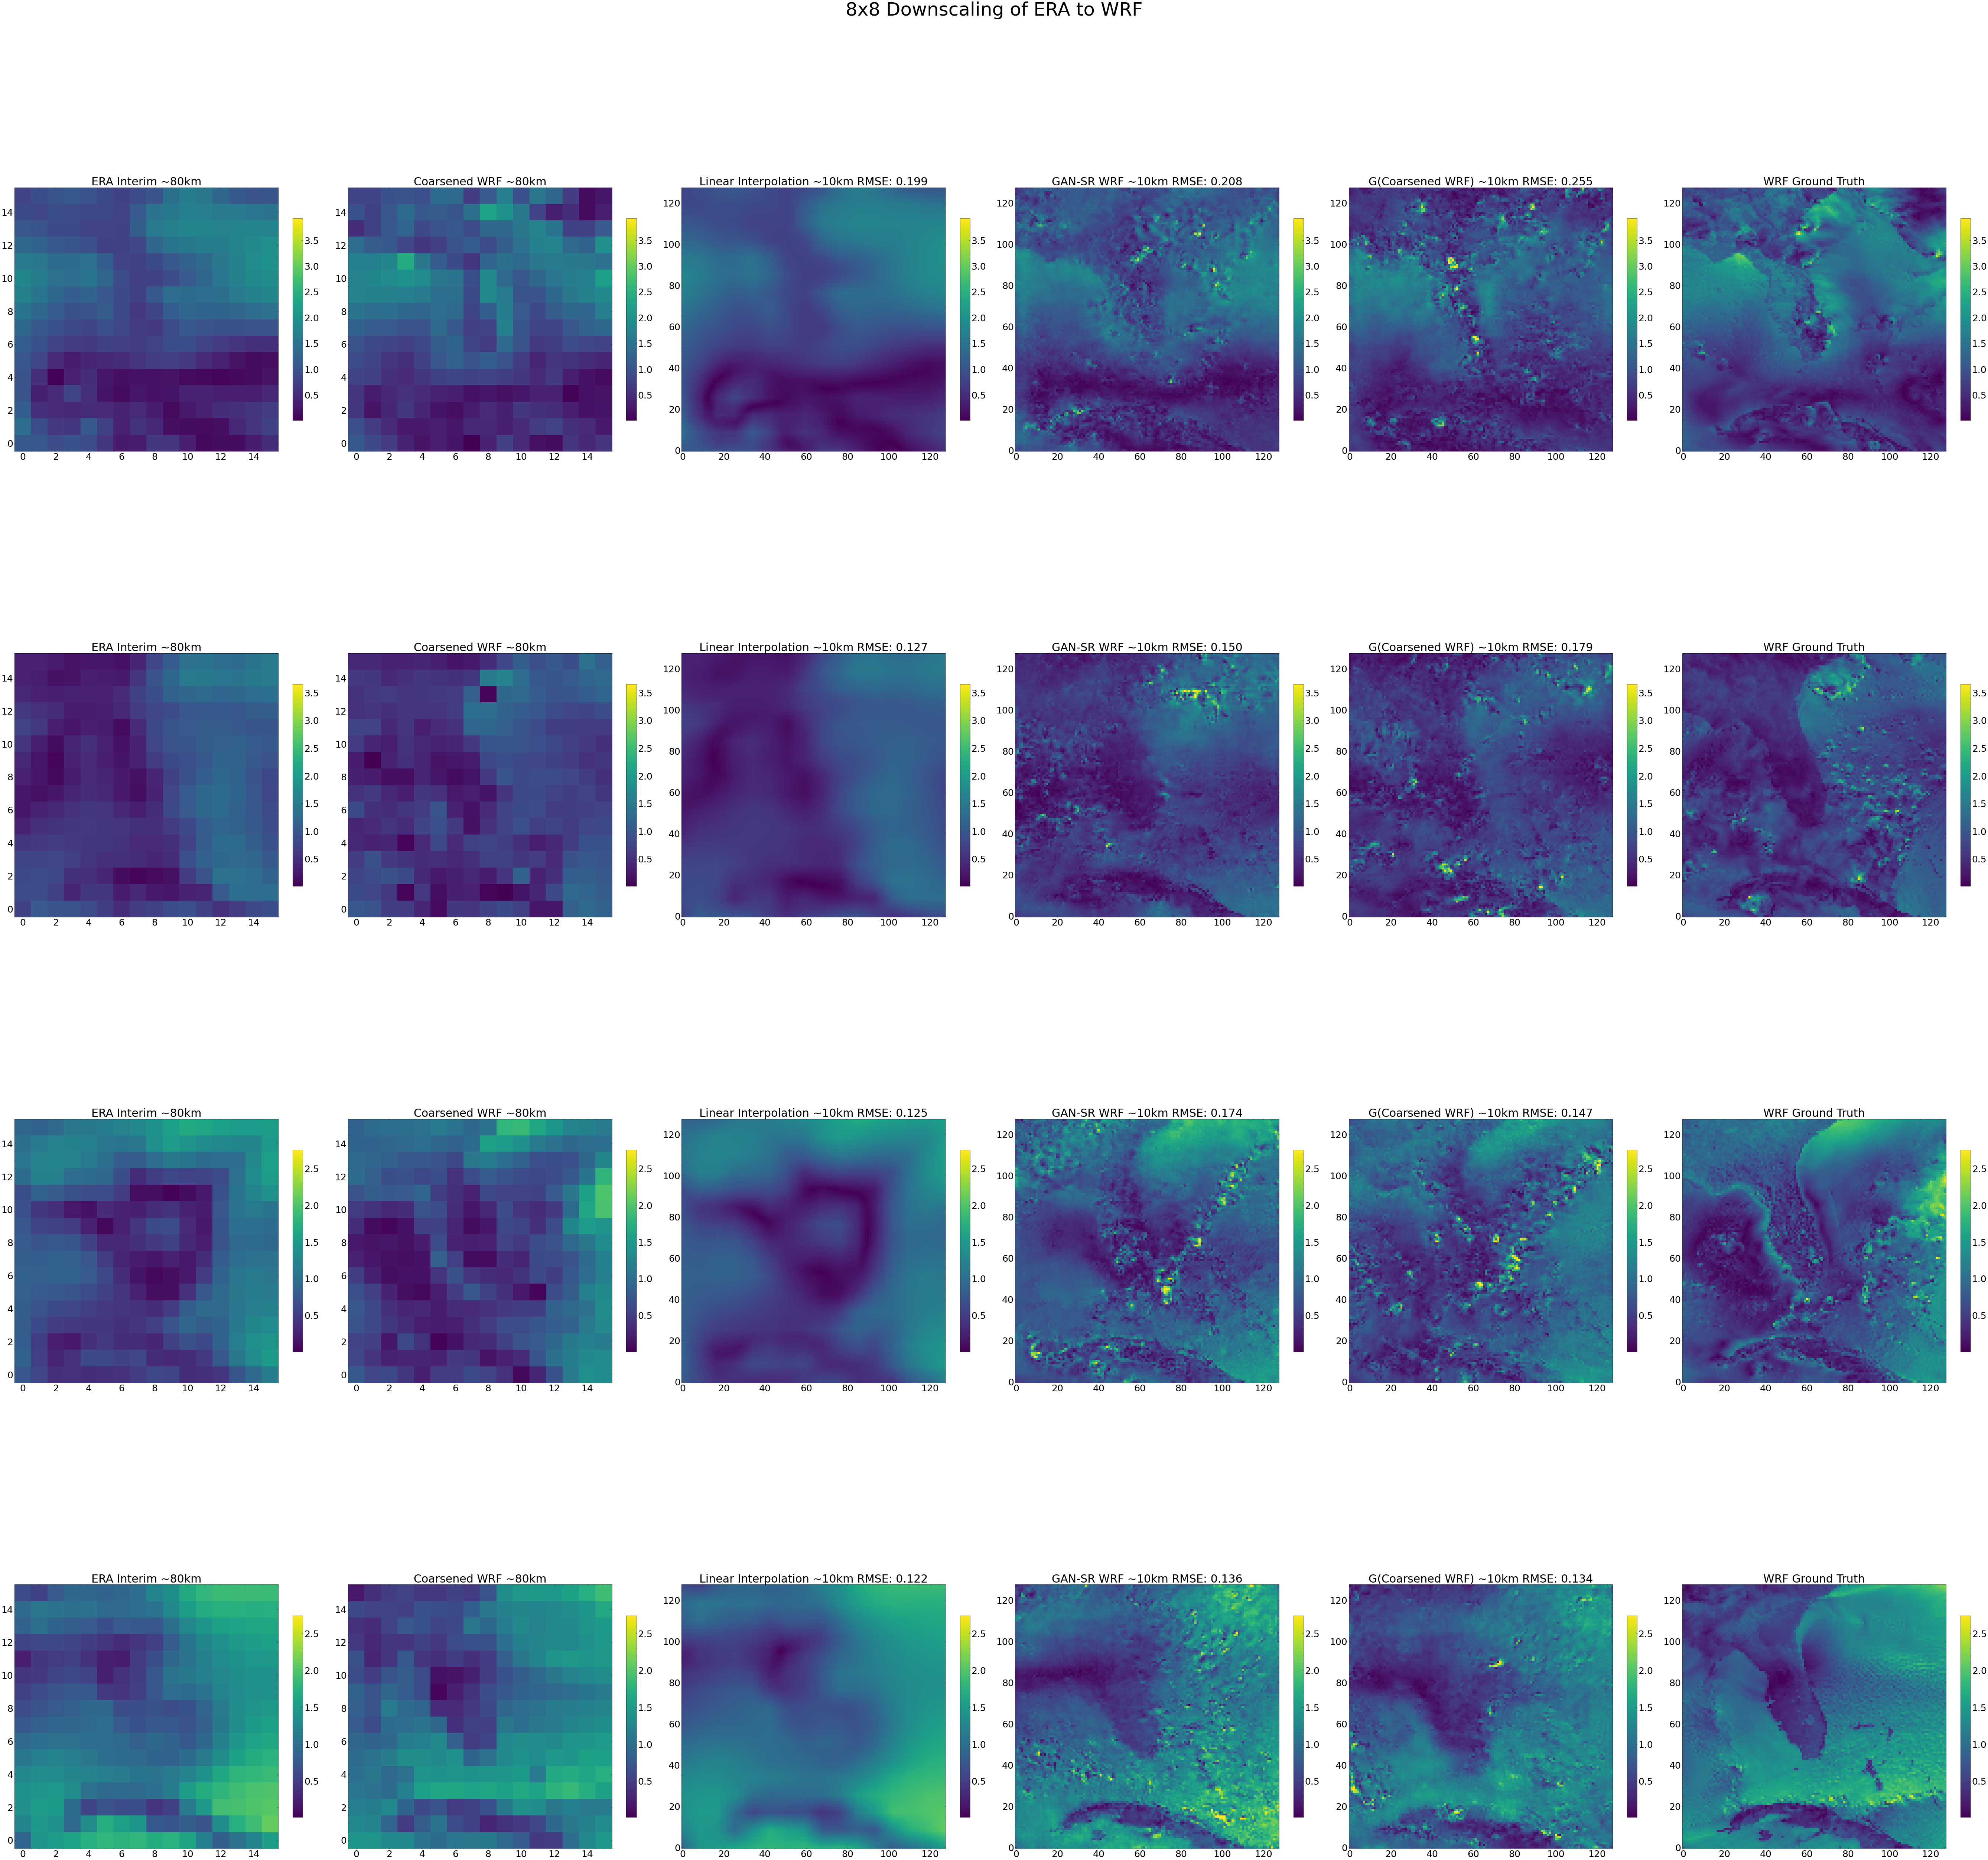

In [35]:
fig, ax = plt.subplots(4, 6, figsize=(75, 75))
# np.random.seed(500)
N1 = 3
N2 = N1+3


for j in range(4):
#     i = np.random.choice(i_list[time_mask], 1)[0]
    print("i", i)
    i = np.random.randint(0, batch_size)

    
#     fake = G(fixed["coarse"].float().to(device)).detach().cpu().numpy()[i, 1, ...]
#     real = fixed["fine"].detach().numpy()[i, 1, ...]
#     coarse = fixed["coarse"].detach().numpy()[i, 1, ...]
    coarse_hypot = np.hypot(fixed["coarse"].detach().numpy()[i, 0, ...], fixed["coarse"].detach().numpy()[i, 1, ...])
        
    u10_fake = G(fixed["coarse"].float().to(device)).detach().cpu().numpy()[i, 0, ...]
    v10_fake = G(fixed["coarse"].float().to(device)).detach().cpu().numpy()[i, 1, ...]

    real = fixed["fine"].detach().numpy()[i, 1, ...]

    u10_real = fixed["fine"].detach().numpy()[i, 0, ...]
    v10_real = fixed["fine"].detach().numpy()[i, 1, ...]

    coarse_wrf = torch.from_numpy(xr.DataArray(fixed["fine"]).coarsen(dim_2=8).mean().coarsen(dim_3=8).mean().values).to(device)
    coarse_wrf_hypot = np.hypot(coarse_wrf.detach().cpu().numpy()[i, 0, ...], coarse_wrf.detach().cpu().numpy()[i, 1, ...])
    
    u10_wrf_fake = G(coarse_wrf).detach().cpu().numpy()[i, 0, ...]
    v10_wrf_fake = G(coarse_wrf).detach().cpu().numpy()[i, 1, ...]
    speed_wrf_fake = np.hypot(u10_wrf_fake, v10_wrf_fake)

    speed_fake = np.hypot(u10_fake, v10_fake)
    speed_real = np.hypot(u10_real, v10_real)
    
    flin_u10 = interp2d(x, y, fixed["coarse"].detach().numpy()[i, 0, ...], kind='linear')
    naive_lin_u10 = flin_u10(nx, ny)
        
    flin_v10 = interp2d(x, y, fixed["coarse"].detach().numpy()[i, 1, ...], kind='linear')
    naive_lin_v10 = flin_v10(nx, ny)
    
    naive_lin_speed = np.hypot(naive_lin_u10, naive_lin_v10)

    mse_naive = mean_squared_error(naive_lin_speed.flatten(), speed_real.flatten())
    mse_fake = mean_squared_error(speed_fake.flatten(), speed_real.flatten())
    mse_fake_wrf_coarse = mean_squared_error(speed_wrf_fake.flatten(), speed_real.flatten())
    
    
#     flin = interp2d(x, y, coarse, kind='linear')
#     naive_lin = flin(nx, ny)
    
    # Regressing leading EOFs
#     reg = LinearRegression().fit(fine_sp_basis_v10.T, real.flatten())
#     leading_eofs = reg.predict(fine_sp_basis_v10.T).reshape(real.shape)
#     vmin, vmax = -2,3.5 
#     ax[j, 0].imshow(coarse_hypot, origin="lower")#, vmin=vmin, vmax=vmax)
#     ax[j, 0].set_title("ERA-Interim LR")
#     ax[j, 1].imshow(speed_fake, origin="lower",)# vmin=vmin, vmax=vmax)
#     ax[j, 1].set_title("GAN-SR")
#     ax[j, 2].imshow(speed_real, origin="lower",)# vmin=vmin, vmax=vmax)
#     ax[j, 2].set_title("Ground Truth WRF")
    
    vmin, vmax = speed_real.min(), speed_real.max()
    
    cbar = ax[j, 0].imshow(coarse_hypot, origin="lower", vmin=vmin, vmax=vmax)
    fig.colorbar(cbar, ax=ax[j, 0], orientation="vertical", fraction=0.035, pad = 0.05)
    ax[j, 0].set_title(f"ERA Interim ~80km")
    
    cbar = ax[j, 1].imshow(coarse_wrf_hypot, origin="lower", vmin=vmin, vmax=vmax)
    fig.colorbar(cbar, ax=ax[j, 1], orientation="vertical", fraction=0.035, pad = 0.05)
    ax[j, 1].set_title(f"Coarsened WRF ~80km")
    
    cbar = ax[j, 2].imshow(naive_lin_speed, origin="lower", vmin=vmin, vmax=vmax)
    fig.colorbar(cbar, ax=ax[j, 2], orientation="vertical", fraction=0.035, pad = 0.05)
    ax[j, 2].set_title(f"Linear Interpolation ~10km RMSE: {mse_naive:.3f}")
    
    cbar = ax[j, 3].imshow(speed_fake, origin="lower", vmin=vmin, vmax=vmax)
    fig.colorbar(cbar, ax=ax[j, 3], orientation="vertical", fraction=0.035, pad = 0.05)
    ax[j, 3].set_title(f"GAN-SR WRF ~10km RMSE: {mse_fake:.3f}")
#     ax[j, 3].imshow(leading_eofs)
#     ax[j, 3].set_title(f"Leading {ncomp} EOFs Linearly Regressed Against Ground Truth")
    
    cbar = ax[j, 4].imshow(speed_wrf_fake, origin="lower", vmin=vmin, vmax=vmax)
    fig.colorbar(cbar, ax=ax[j, 4], orientation="vertical", fraction=0.035, pad = 0.05)
    ax[j, 4].set_title(f"G(Coarsened WRF) ~10km RMSE: {mse_fake_wrf_coarse:.3f}")

    cbar = ax[j, 5].imshow(speed_real, origin="lower", vmin=vmin, vmax=vmax)
    fig.colorbar(cbar, ax=ax[j, 5], orientation="vertical", fraction=0.035, pad = 0.05)
    ax[j, 5].set_title("WRF Ground Truth")

fig.suptitle('8x8 Downscaling of ERA to WRF', fontsize=50, y=1)
plt.tight_layout()
plt.savefig(f"artifacts/{hashed}/sis_gan_grid_adversarial{i}.png", facecolor='white')

# fig.suptitle('Speed 8x8 Downscaling of ERA Interm Surface Wind Magnitudes with 500 Epochs', fontsize=50, y=0.9)
# plt.savefig(f"sisr_gan_grid_gradient_loss_speed_{i}.png", facecolor='white')

In [36]:
N = 2704
N_epochs = 450
r = N/N_epochs
a = 27
(1/a)*N



100.14814814814814

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple


class MedianPool2d(nn.Module):
    """ Median pool (usable as median filter when stride=1) module.
    
    Args:
         kernel_size: size of pooling kernel, int or 2-tuple
         stride: pool stride, int or 2-tuple
         padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
         same: override padding and enforce same padding, boolean
    """
    def __init__(self, kernel_size=9, stride=1, padding=4, same=False):
        super(MedianPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding
    
    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd, 
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        # x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        x = x.contiguous().view(x.size()[:4] + (-1,)).mean(dim=-1)[0]
        return x

In [2]:
torch.cuda.empty_cache()

In [3]:
med = MedianPool2d()

In [4]:
med_fine = med(fixed["fine"].to(device))

NameError: name 'fixed' is not defined

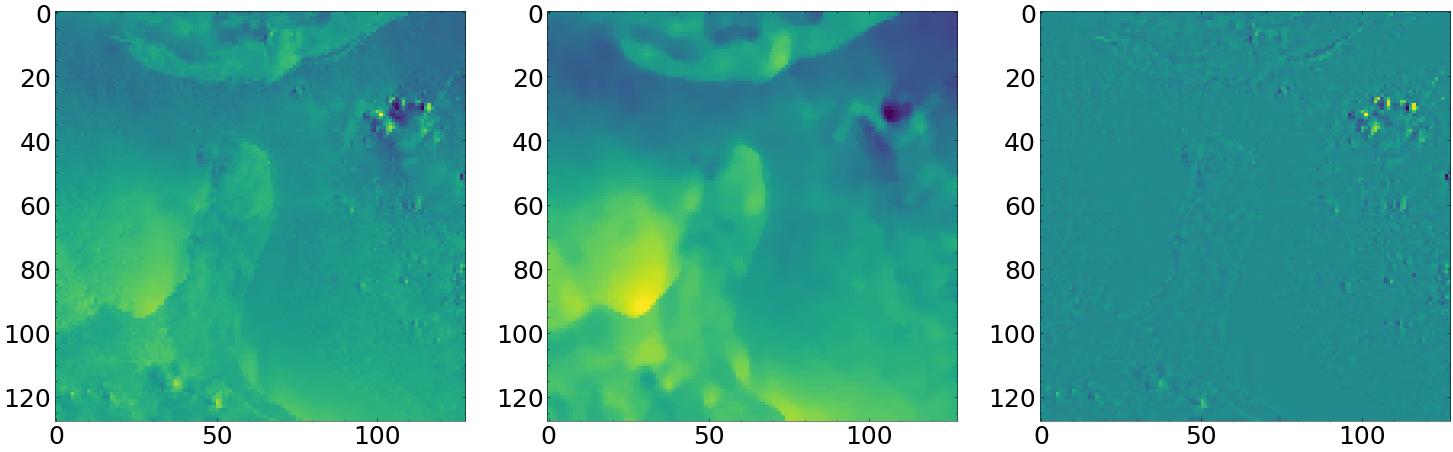

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(25, 40))
ax[0].imshow(fixed["fine"][0, 0, ...])
ax[1].imshow(med_fine[0, 0, ...].cpu().detach().numpy())
ax[2].imshow(fixed["fine"][0, 0, ...]-med_fine[0, 0, ...].cpu().detach().numpy())

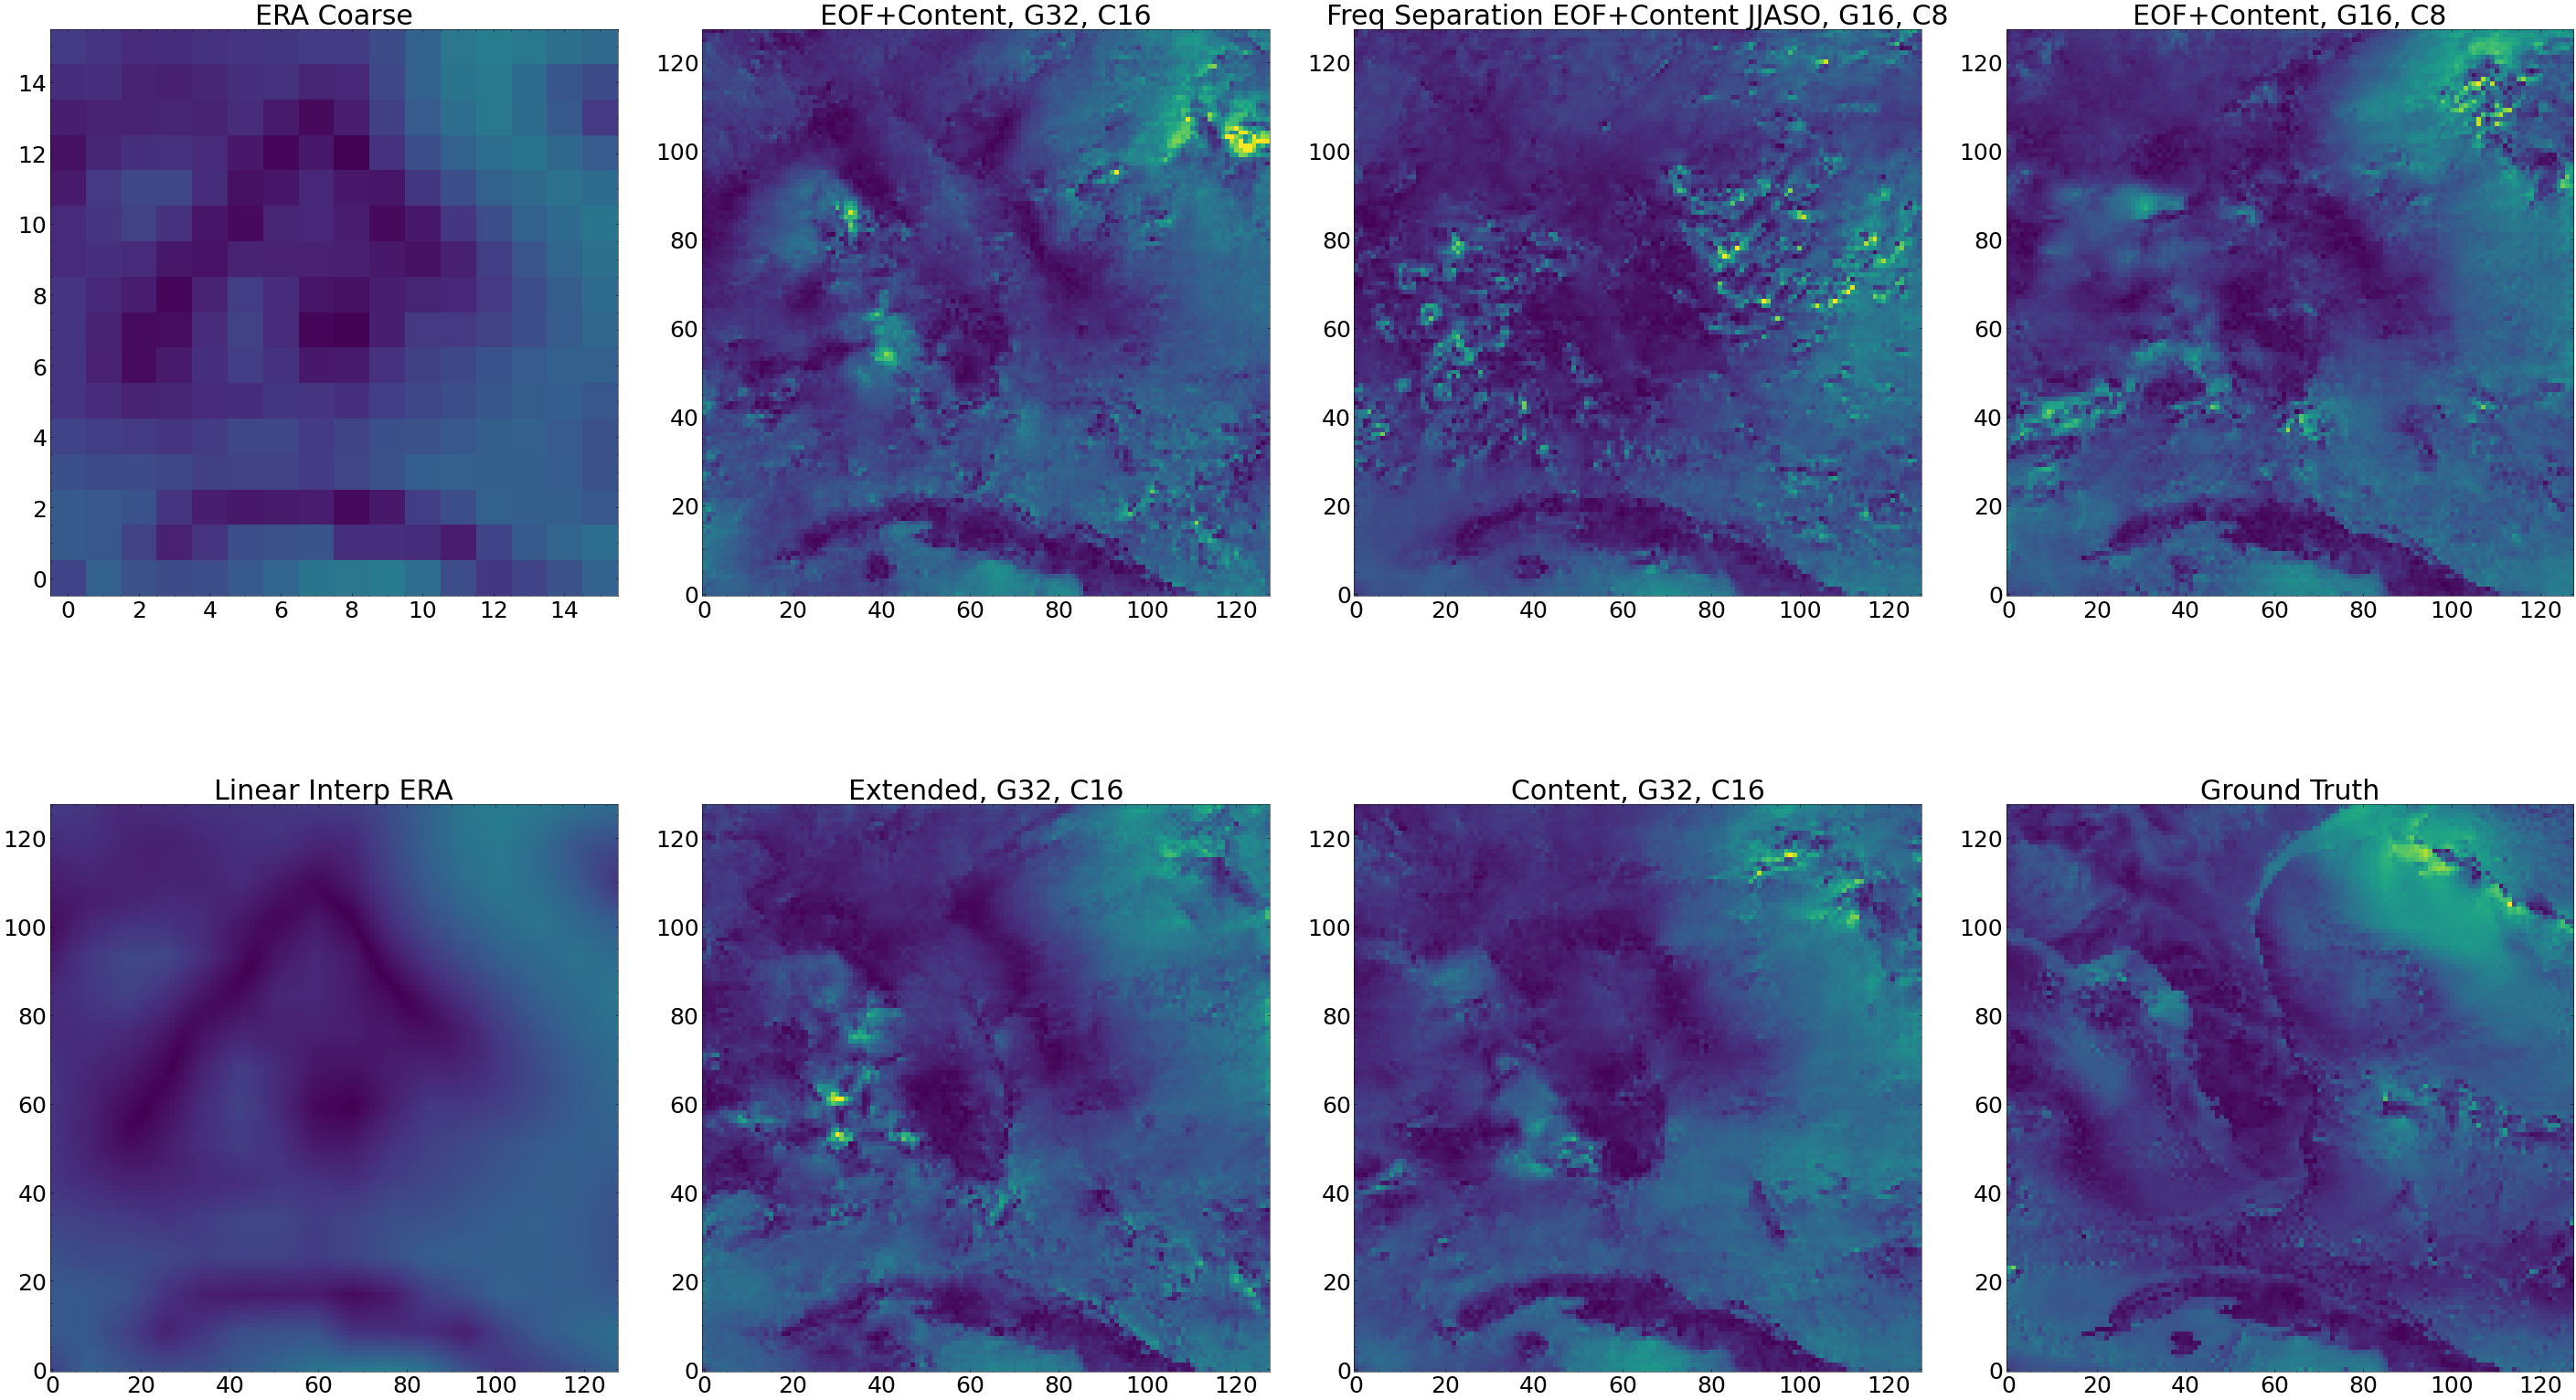

In [51]:
hash_trained = {
    "8c8d6c528fdd47169763b0a30cd847dc": ("EOF+Content, G32, C16", (0, 1)),
#     "8b854a5d4fa441ba9edc7041f90568ec": ("EOF+Content Run 2, G32, C16", (0, 2)),
    "5347f0446e364ece98f3d652436f8462": ("Freq Separation EOF+Content JJASO, G16, C8", (0, 2)),    
    "89ab7d6b0c9e447fa7ae3ca30044f06c": ("EOF+Content, G16, C8", (0, 3)),
    "5515c927593747b585616cad56d0efba": ("Extended, G32, C16", (1, 1)),
    "ff26e9c163a1475686964d1586812bc8": ("Content, G32, C16", (1, 2)),
}
i = np.random.randint(0, batch_size)

flin_u10 = interp2d(x, y, fixed["coarse"].detach().numpy()[i, 0, ...], kind='linear')
naive_lin_u10 = flin_u10(nx, ny)

flin_v10 = interp2d(x, y, fixed["coarse"].detach().numpy()[i, 1, ...], kind='linear')
naive_lin_v10 = flin_v10(nx, ny)

naive_lin_speed = np.hypot(naive_lin_u10, naive_lin_v10)

coarse_wrf = torch.from_numpy(xr.DataArray(fixed["fine"]).coarsen(dim_2=8).mean().coarsen(dim_3=8).mean().values).to(device)
coarse_wrf_hypot = np.hypot(coarse_wrf.detach().cpu().numpy()[i, 0, ...], coarse_wrf.detach().cpu().numpy()[i, 1, ...])
coarse_hypot = np.hypot(fixed["coarse"].detach().numpy()[i, 0, ...], fixed["coarse"].detach().numpy()[i, 1, ...])    

real = fixed["fine"].detach().numpy()[i, 1, ...]
u10_real = fixed["fine"].detach().numpy()[i, 0, ...]
v10_real = fixed["fine"].detach().numpy()[i, 1, ...]
speed_real = np.hypot(u10_real, v10_real)

vmin, vmax = speed_real.min(), speed_real.max()


fig, ax = plt.subplots(2, 4, figsize=(40, 25))

ax[0, 0].imshow(coarse_hypot, origin="lower", label="coarse", vmin=vmin, vmax=vmax)
ax[0, 0].set_title("ERA Coarse")

ax[1, 0].imshow(naive_lin_speed, origin="lower", label="linear interp", vmin=vmin, vmax=vmax )
ax[1, 0].set_title("Linear Interp ERA")

ax[1, 3].imshow(speed_real, origin="lower", vmin=vmin, vmax=vmax)
ax[1, 3].set_title("Ground Truth")

for hash_code in hash_trained.keys():
    
    lab, pos = hash_trained[hash_code]
    logged_model = f'file:///home/nannau/msc/DoWnGAN/mlruns/1/{hash_code}/artifacts/Generator'
    G = mlflow.pytorch.load_model(logged_model).to(device)
    state_dict = mlflow.pytorch.load_state_dict(logged_model)#state_dict.pth")
    G.load_state_dict(state_dict)

    u10_fake = G(fixed["coarse"].float().to(device)).detach().cpu().numpy()[i, 0, ...]
    v10_fake = G(fixed["coarse"].float().to(device)).detach().cpu().numpy()[i, 1, ...]

    
    u10_wrf_fake = G(coarse_wrf).detach().cpu().numpy()[i, 0, ...]
    v10_wrf_fake = G(coarse_wrf).detach().cpu().numpy()[i, 1, ...]
    speed_wrf_fake = np.hypot(u10_wrf_fake, v10_wrf_fake)

    speed_fake = np.hypot(u10_fake, v10_fake)
    
    mse_naive = mean_squared_error(naive_lin_speed.flatten(), speed_real.flatten())
    mse_fake = mean_squared_error(speed_fake.flatten(), speed_real.flatten())
    mse_fake_wrf_coarse = mean_squared_error(speed_wrf_fake.flatten(), speed_real.flatten())
    
    ax[pos].imshow(speed_fake, origin="lower", vmin=vmin, vmax=vmax)
    ax[pos].set_title(lab)

plt.tight_layout()
plt.savefig(f"artifacts/{hashed}/comparisons/visual_comparison_{i}_JJASO")

/home/nannau/tri/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nannau/tri/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/nannau/tri/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nannau/tri/lib/python3.8/site-packages/seabo

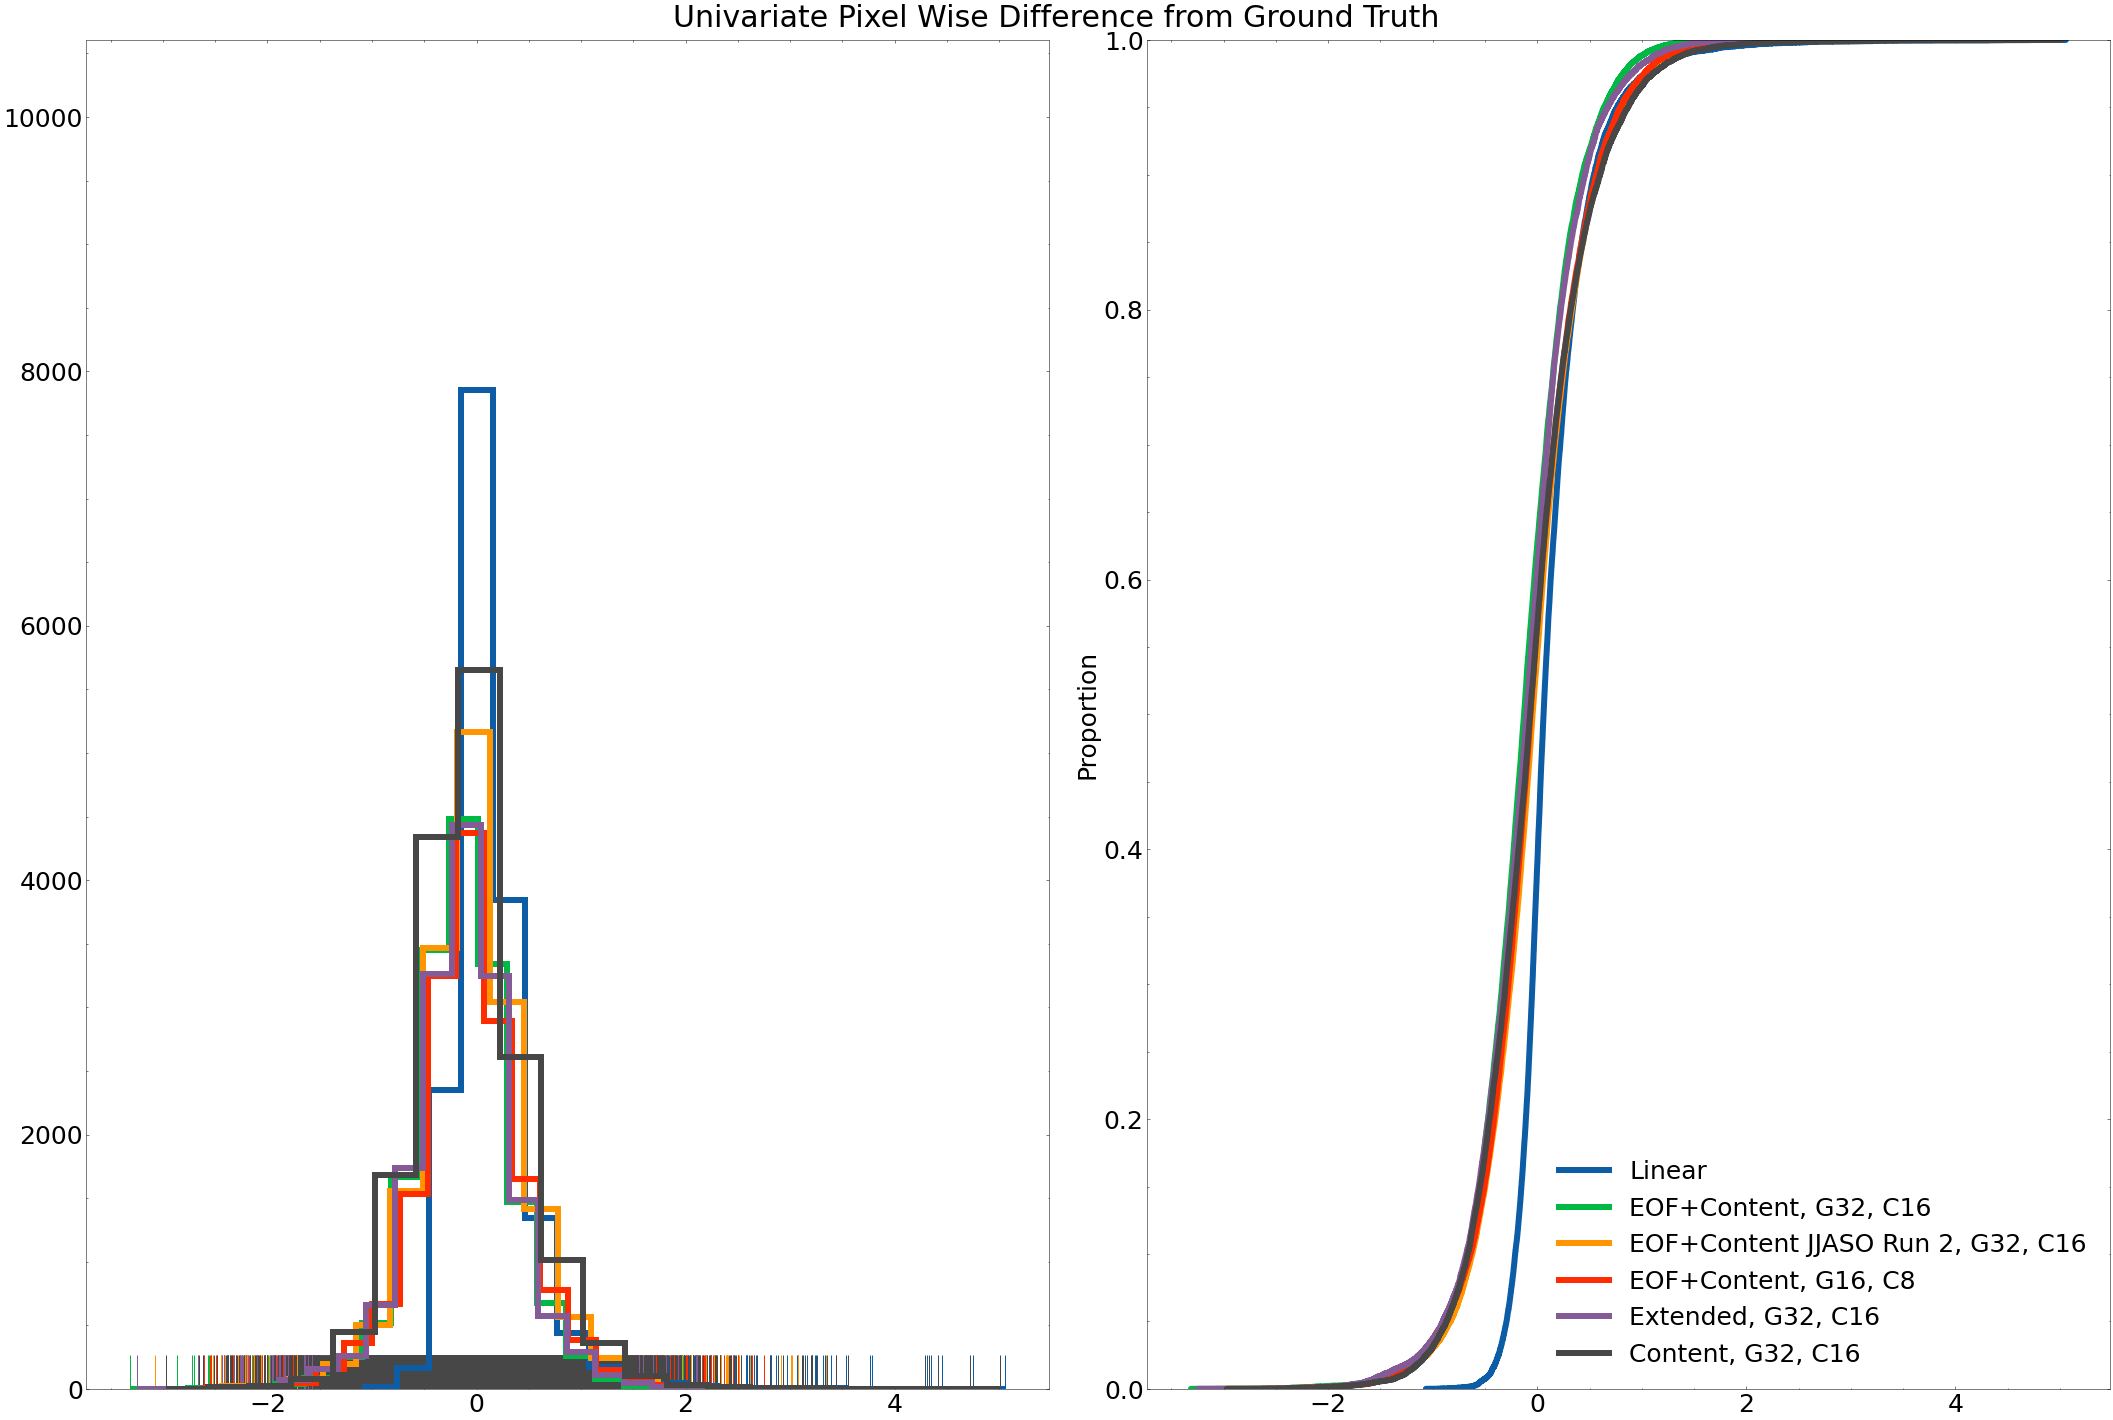

In [43]:

fig, ax = plt.subplots(1, 2, figsize=(30, 20))
sns.distplot(speed_fake-naive_lin_speed, ax=ax[0], label="Linear", rug=True, kde=False, bins=20, hist_kws={"histtype": "step", "linewidth": 6,"alpha": 1})
sns.ecdfplot(speed_fake.flatten()-naive_lin_speed.flatten(), ax=ax[1], label="Linear", linewidth=6)

for hash_code in hash_trained.keys():
    
    lab, pos = hash_trained[hash_code]
    logged_model = f'file:///home/nannau/msc/DoWnGAN/mlruns/1/{hash_code}/artifacts/Generator'
    G = mlflow.pytorch.load_model(logged_model).to(device)
    state_dict = mlflow.pytorch.load_state_dict(logged_model)#state_dict.pth")
    G.load_state_dict(state_dict)

    u10_fake = G(fixed["coarse"].float().to(device)).detach().cpu().numpy()[i, 0, ...]
    v10_fake = G(fixed["coarse"].float().to(device)).detach().cpu().numpy()[i, 1, ...]
    
    u10_wrf_fake = G(coarse_wrf).detach().cpu().numpy()[i, 0, ...]
    v10_wrf_fake = G(coarse_wrf).detach().cpu().numpy()[i, 1, ...]
    speed_wrf_fake = np.hypot(u10_wrf_fake, v10_wrf_fake)

    speed_fake = np.hypot(u10_fake, v10_fake)
    
    mse_naive = mean_squared_error(naive_lin_speed.flatten(), speed_real.flatten())
    mse_fake = mean_squared_error(speed_fake.flatten(), speed_real.flatten())
    mse_fake_wrf_coarse = mean_squared_error(speed_wrf_fake.flatten(), speed_real.flatten())
    
    sns.distplot(speed_fake-speed_real, ax=ax[0], label=lab, rug=True, kde=False, bins=20, hist_kws={"histtype": "step", "linewidth": 6,"alpha": 1})
    sns.ecdfplot(speed_fake.flatten()-speed_real.flatten(), ax=ax[1], label=lab, linewidth=6)
#     plt.semilogy(ax=ax[1])

    
plt.tight_layout()
plt.legend()
fig.suptitle("Univariate Pixel Wise Difference from Ground Truth", y=1)
plt.savefig(f"artifacts/comparisons/distribution_comparison_{i}")